In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

From EDA, some values within some columns could potentially be merged or interpreted in another way. These values in some columns were replaced or merged in this notebook. A chained Random Forest model is used to evaluate the effect of changing the values.

In [ ]:
# Import dataset
data = pd.read_csv("train.csv")
print('Dimension of original data \t:', data.shape)

# Drop duplicates, if any, based on unique Patient Id
data = data.drop_duplicates(subset = "Patient Id")

# Drop irrelevant columns
drop_columns = ["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name", "Location of Institute",
                "Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent", "Place of birth"]
data = data.drop(drop_columns, axis = 1)

# Drop rows with missing Disorder Subclass
data = data.dropna(axis = 0, how = 'any', subset = ["Disorder Subclass"])

# Fill ambiguous observations with missing values
data.replace(['Ambiguous', 'No record', 'Not available', 'Not applicable', '-'], np.nan, inplace = True)
data['Autopsy shows birth defect (if applicable)'].replace('None', 'No', inplace = True)

data["No. of previous abortion"].replace({0: "0", 1: "1", 2: "2", 3: "3", 4: "4"}, inplace = True)

data = data.reset_index()

# Rename columns
data.rename(columns = {"Patient Age": "Patient's age",
                       "Genes in mother's side": "Inherited from mother",
                       "Autopsy shows birth defect (if applicable)": "Autopsy shows birth defect",
                       "Blood cell count (mcL)": "Blood cell count (million/mcL)",
                       "White Blood cell count (thousand per microliter)": "White blood cell count (thousand/mcL)",
                       "Respiratory Rate (breaths/min)": "Respiratory rate (breaths/min)",
                       "Heart Rate (rates/min" : "Heart rate (beats/min)",
                       "History of anomalies in previous pregnancies": "H/O anomalies in previous pregnancies"},
                  inplace = True)

# Fill missing values in Genetic Disorder based on Disorder Subclass
for x in data[data['Genetic Disorder'].isnull() == False]:
    subclass_dict = data.set_index('Disorder Subclass')['Genetic Disorder'].to_dict()
    
    subclass_dict["Leigh syndrome"] = "Mitochondrial genetic inheritance disorders"
    subclass_dict["Cancer"] = "Multifactorial genetic inheritance disorders"
    subclass_dict["Alzheimer's"] = "Multifactorial genetic inheritance disorders"
    
    data["Genetic Disorder"] = data['Disorder Subclass'].apply(lambda x: subclass_dict.get(x))

data["Genetic Disorder"].replace(["Mitochondrial genetic inheritance disorders", "Multifactorial genetic inheritance disorders",
                                  "Single-gene inheritance diseases"], ["Mitochondrial", "Multifactorial", "Single-gene"],
                                    inplace = True)

data.drop('index', axis = 1, inplace = True)        

# Bin the continous variables to convert into ordinal categorical variables
pa_edges = np.histogram_bin_edges(data['Patient\'s age'].dropna(), bins = 5)
data['Patient\'s age'] = pd.cut(data['Patient\'s age'], bins = pa_edges, labels = [x for x in range(len(pa_edges) - 1)])

ma_edges = np.histogram_bin_edges(data['Mother\'s age'].dropna(), bins = 6)
data['Mother\'s age'] = pd.cut(data['Mother\'s age'], bins = ma_edges, labels = [x for x in range(len(ma_edges) - 1)])

fa_edges = np.histogram_bin_edges(data['Father\'s age'].dropna(), bins = 6)
data['Father\'s age'] = pd.cut(data['Father\'s age'], bins = fa_edges, labels = [x for x in range(len(fa_edges) - 1)])

bcc_edges = np.histogram_bin_edges(data['Blood cell count (million/mcL)'].dropna(), bins = 4)
data['Blood cell count (million/mcL)'] = pd.cut(data['Blood cell count (million/mcL)'], bins = bcc_edges, labels = [x for x in range(len(bcc_edges) - 1)])

wbcc_edges = np.histogram_bin_edges(data['White blood cell count (thousand/mcL)'].dropna(), bins = 4)
data['White blood cell count (thousand/mcL)'] = pd.cut(data['White blood cell count (thousand/mcL)'], bins = wbcc_edges, labels = [x for x in range(len(wbcc_edges) - 1)])

Dimension of original data 	: (22083, 45)


In [ ]:
# Import libraries
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split

# Label encode all variables
encoder = defaultdict(LabelEncoder)
encoded_data = data_drop.apply(lambda series: pd.Series(encoder[series.name].fit_transform(series[series.notnull()]), index = series[series.notnull()].index))
encoded_data.head()

# Separate into predictors and response variables
X = encoded_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis = 1)
y = encoded_data[['Genetic Disorder', 'Disorder Subclass']]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

# Iterative imputation based on Multivariate Imputation by Chained Equations (MICE) using Naive Bayes model
# Use Naive Bayes as it disregards ordinality so that it is easier to impute all in one go
imputer_nb = IterativeImputer(estimator = CategoricalNB(), initial_strategy='constant', max_iter = 200)

X_train_imp_nb = pd.DataFrame()
X_test_imp_nb = pd.DataFrame()

X_train_imp_nb[X_train.columns] = imputer_nb.fit_transform(X_train)
X_test_imp_nb[X_test.columns] = imputer_nb.transform(X_test)

# Decode back to original values from label encoder
imputed_unenc_X_train = pd.DataFrame()
for x in X_train_imp_nb:
  imputed_unenc_X_train[x] = list(encoder[x].inverse_transform(X_train_imp_nb[x].apply(lambda y: int(y))))

imputed_unenc_X_test = pd.DataFrame()
for x in X_test_imp_nb:
  imputed_unenc_X_test[x] = list(encoder[x].inverse_transform(X_test_imp_nb[x].apply(lambda y: int(y))))

unenc_y_train = pd.DataFrame()
for x in y_train:
  unenc_y_train[x] = list(encoder[x].inverse_transform(y_train[x].apply(lambda y: int(y))))

unenc_y_test = pd.DataFrame()
for x in y_test:
  unenc_y_test[x] = list(encoder[x].inverse_transform(y_test[x].apply(lambda y: int(y))))

In [ ]:
### Supervised
## One-hot encoding

# Reform whole imputed dataset
data_drop_imputed = pd.concat([pd.concat([imputed_unenc_X_train, unenc_y_train],axis = 1),pd.concat([imputed_unenc_X_test, unenc_y_test],axis = 1)],axis =0)

ordinal_converter = {'Birth defects':['Singular','Multiple']}
for k, v in ordinal_converter.items():
  data_drop_imputed[k] = [v.index(x) for x in data_drop_imputed[k]]

# Classify nominal and ordinal data
ordinal = []
nominal = []
for i in data_drop_imputed:
  if isinstance(list(data_drop_imputed[i].unique())[0], np.int64) or isinstance(list(data_drop_imputed[i].unique())[0], np.float64):
    ordinal.append(i)
  else:
    nominal.append(i)

# One Hot encoding to all to account for nominal data
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
encoder = defaultdict(OneHotEncoder)
data_drop_encoded = data_drop_imputed.copy()
nominal.remove('Disorder Subclass')
nominal.remove('Genetic Disorder')
data_drop_encoded.drop(labels = nominal, axis = 1, inplace = True)
for i in nominal:
  data_drop_encoded = pd.concat([data_drop_encoded, pd.DataFrame(encoder[i].fit_transform(data_drop_imputed[[i]]).toarray(), index = data_drop_imputed[[i]].index, columns = encoder[i].get_feature_names_out ())], axis = 1)

X = data_drop_encoded.drop(['Disorder Subclass', 'Genetic Disorder'], axis = 1)
y = data_drop_encoded[['Disorder Subclass', 'Genetic Disorder']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

In [ ]:
##SMOTE oversampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

y_SC = data_encoded[['Disorder Subclass']]
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    smote_sample = SMOTE()
    X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
    X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass'])  # Train test split stratified by Disorder subclass
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder'])
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
    X_train.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test.drop('Genetic Disorder', axis = 1, inplace = True)
    X_train.reset_index(inplace = True)
    X_train.drop('index', axis = 1, inplace = True)
    X_test.reset_index(inplace = True)
    X_test.drop('index', axis = 1, inplace = True)

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3, n_jobs = -1) # Instantiate model
    randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder'])) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.543376,0.540655,0.540152,0.538914
std,0.006745,0.008028,0.004529,0.006284
min,0.531546,0.521318,0.531761,0.526704
25%,0.538511,0.535691,0.536937,0.534938
50%,0.543981,0.541559,0.540321,0.539729
75%,0.548537,0.545435,0.543443,0.541666
max,0.558543,0.555663,0.548207,0.559218


In [ ]:
# Change depth of Random Forest
# SMOTE based on Disorder Subclass statification

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_encoded[['Disorder Subclass']]
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())


for depth in range(1,11,1):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder'])
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = 100, max_depth = depth, n_jobs = -1) # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder']))  # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean())  # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

  print('Tree depth :', depth)
  display(pd.DataFrame(all_scores).describe())

Tree depth : 1


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.464988,0.464660,0.462092,0.460454
std,0.005353,0.006824,0.004582,0.005624
min,0.454457,0.451012,0.451712,0.449506
25%,0.462795,0.460191,0.459942,0.456208
50%,0.464941,0.464416,0.462586,0.461186
75%,0.468292,0.470715,0.465083,0.464497
max,0.474995,0.477390,0.468723,0.471468


Tree depth : 2


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.508940,0.509733,0.507851,0.506273
std,0.003084,0.005047,0.001992,0.004470
min,0.503445,0.498600,0.504091,0.494940
25%,0.506325,0.506083,0.506850,0.504010
50%,0.509004,0.509582,0.508088,0.506082
75%,0.511036,0.513270,0.508667,0.509313
max,0.514266,0.518842,0.511789,0.514642


Tree depth : 3


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.556679,0.554131,0.551829,0.548428
std,0.009504,0.009217,0.003627,0.004976
min,0.535933,0.538006,0.545892,0.541668
25%,0.550085,0.549338,0.549096,0.544225
50%,0.555865,0.552487,0.551518,0.547213
75%,0.565427,0.560966,0.554156,0.552433
max,0.575070,0.574505,0.558436,0.560617


Tree depth : 4


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.594128,0.590461,0.589281,0.586740
std,0.003561,0.004566,0.002556,0.005034
min,0.585029,0.580857,0.584329,0.577304
25%,0.591859,0.586779,0.587189,0.582577
50%,0.594248,0.591677,0.589766,0.586780
75%,0.595930,0.593750,0.591031,0.589095
max,0.601206,0.597653,0.593750,0.599052


Tree depth : 5


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.616946,0.610469,0.609248,0.606374
std,0.002737,0.005275,0.001906,0.003894
min,0.609550,0.600129,0.605459,0.596683
25%,0.615398,0.607693,0.607989,0.604274
50%,0.617208,0.610788,0.609294,0.606158
75%,0.618486,0.613668,0.610439,0.608986
max,0.622255,0.619940,0.613560,0.612727


Tree depth : 6


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.640647,0.629375,0.629101,0.620865
std,0.003061,0.003587,0.001898,0.004543
min,0.633963,0.622308,0.625511,0.611328
25%,0.638088,0.627180,0.627651,0.617301
50%,0.641096,0.629522,0.629239,0.621232
75%,0.642920,0.631460,0.629939,0.623518
max,0.645645,0.638566,0.632564,0.631891


Tree depth : 7


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.670384,0.651016,0.649591,0.636632
std,0.002594,0.004025,0.001642,0.004400
min,0.664137,0.644811,0.646479,0.629626
25%,0.669035,0.648040,0.648215,0.633750
50%,0.670354,0.649602,0.649561,0.637059
75%,0.672104,0.654689,0.650880,0.640290
max,0.676195,0.661176,0.652482,0.644058


Tree depth : 8


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.707356,0.673715,0.670791,0.652440
std,0.002086,0.003463,0.001786,0.004391
min,0.702385,0.666774,0.666963,0.645350
25%,0.706180,0.672104,0.670024,0.649091
50%,0.707230,0.673127,0.670933,0.652239
75%,0.708569,0.675657,0.671686,0.656277
max,0.711967,0.683786,0.673611,0.661178


Tree depth : 9


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.751968,0.697125,0.693528,0.667987
std,0.001766,0.003487,0.001795,0.004585
min,0.749139,0.688415,0.689465,0.658269
25%,0.750390,0.694767,0.692439,0.665052
50%,0.752059,0.697674,0.693112,0.667798
75%,0.753304,0.699128,0.694768,0.671162
max,0.755545,0.703811,0.697136,0.677972


Tree depth : 10


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.809911,0.720977,0.716345,0.681579
std,0.002570,0.004330,0.001362,0.003744
min,0.803321,0.706718,0.713286,0.673448
25%,0.808543,0.718427,0.715594,0.679964
50%,0.809741,0.720876,0.716166,0.681847
75%,0.811625,0.723810,0.717606,0.683518
max,0.816349,0.728252,0.718885,0.688523


In [ ]:
# Change number of trees of Random Forest
# SMOTE based on Genetic Disorder statification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y_SC = data_encoded[['Disorder Subclass']]
X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())


for num_tree in range(100,601,100):
  all_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
      smote_sample = SMOTE()
      X_over, y_over = smote_sample.fit_resample(X_GD, y_SC)
      X_train, X_test, y_train_SC, y_test_SC = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over['Disorder Subclass']) # Train test split stratified by Disorder subclass
      y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train['Genetic Disorder']), columns = ['Genetic Disorder'])
      y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test['Genetic Disorder']), columns = ['Genetic Disorder'])
      X_train.drop('Genetic Disorder', axis = 1, inplace = True)
      X_test.drop('Genetic Disorder', axis = 1, inplace = True)
      X_train.reset_index(inplace = True)
      X_train.drop('index', axis = 1, inplace = True)
      X_test.reset_index(inplace = True)
      X_test.drop('index', axis = 1, inplace = True)

      randfor = RandomForestClassifier(n_estimators = num_tree, max_depth = 5, n_jobs = -1)  # Instantiate model
      randfor.fit(X_train, y_train_main['Genetic Disorder']) # Fit model
      all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main['Genetic Disorder'])) # Train set accuracy
      all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main['Genetic Disorder']))  # Test set accuracy
      all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main['Genetic Disorder'], cv = 5).mean()) # Train set 5-fold cross-validation
      all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main['Genetic Disorder'], cv = 5).mean()) # Test set 5-fold cross-validation

  print('Number of Trees :', num_tree)
  display(pd.DataFrame(all_scores).describe())

Number of Trees : 100


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.615785,0.608940,0.609248,0.605031
std,0.002283,0.003831,0.001566,0.005616
min,0.611569,0.600560,0.606778,0.594532
25%,0.614072,0.607289,0.608447,0.600533
50%,0.616050,0.609711,0.608931,0.604489
75%,0.617564,0.610438,0.609913,0.610115
max,0.619321,0.617571,0.613776,0.614554


Number of Trees : 200


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.617032,0.610479,0.609928,0.606535
std,0.002494,0.003952,0.002023,0.004991
min,0.610950,0.602821,0.606481,0.594636
25%,0.615848,0.607800,0.608534,0.602848
50%,0.617100,0.610519,0.609402,0.607128
75%,0.618392,0.613103,0.611084,0.609872
max,0.621985,0.620263,0.614234,0.615310


Number of Trees : 300


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.616905,0.609715,0.609909,0.605588
std,0.002119,0.004137,0.001808,0.003966
min,0.612349,0.603036,0.607100,0.597545
25%,0.616165,0.606428,0.608433,0.602228
50%,0.616925,0.609173,0.609994,0.606426
75%,0.618345,0.613291,0.610855,0.607880
max,0.620478,0.619940,0.614180,0.613374


Number of Trees : 400


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.616872,0.609676,0.610286,0.606075
std,0.001662,0.003904,0.001511,0.003688
min,0.613049,0.600668,0.607101,0.595714
25%,0.616023,0.607558,0.609348,0.603950
50%,0.617113,0.610088,0.609954,0.606212
75%,0.617430,0.612645,0.611084,0.608149
max,0.620720,0.616925,0.613991,0.612618


Number of Trees : 500


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.618329,0.610986,0.610837,0.606880
std,0.001925,0.003768,0.001399,0.004295
min,0.614395,0.604543,0.607047,0.598947
25%,0.617201,0.609065,0.610109,0.603628
50%,0.618675,0.610896,0.610882,0.607128
75%,0.619475,0.612699,0.611986,0.610089
max,0.622281,0.621447,0.613237,0.614987


Number of Trees : 600


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.617519,0.611373,0.610529,0.607027
std,0.002246,0.004542,0.001514,0.004117
min,0.613291,0.602606,0.606589,0.599377
25%,0.615431,0.608635,0.609429,0.603898
50%,0.617773,0.611003,0.611044,0.607128
75%,0.619146,0.612968,0.611703,0.610143
max,0.621259,0.621770,0.612403,0.614452


In [ ]:
# Max depth for SG
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  SG_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass'])# Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene'].index]
    y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene'].index]
    X_train_SG = X_train_SC.loc[y_train_SG.index]
    X_test_SG = X_test_SC.loc[y_test_SG.index]
    randfor_SG = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, n_jobs = -1) # Instantiate model
    randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
    SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
    SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG))  # Test set accuracy
    SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
    SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(SG_scores).describe())

Depth of tree : 1


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.648261,0.643196,0.641146,0.642492
std,0.004583,0.007765,0.005903,0.009037
min,0.639616,0.623062,0.625565,0.617587
25%,0.645086,0.639131,0.636930,0.639712
50%,0.648700,0.644380,0.641996,0.643911
75%,0.651546,0.648175,0.644720,0.647785
max,0.655523,0.661822,0.650354,0.656988


Depth of tree : 2


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.673999,0.665784,0.661357,0.668971
std,0.006043,0.007824,0.004333,0.007703
min,0.661256,0.652778,0.652453,0.653761
25%,0.670300,0.660691,0.657965,0.664585
50%,0.673450,0.665536,0.660811,0.666206
75%,0.678335,0.671915,0.664746,0.674275
max,0.688388,0.680879,0.667957,0.689949


Depth of tree : 3


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.698444,0.684518,0.684720,0.694229
std,0.005435,0.010724,0.003337,0.007725
min,0.685320,0.661822,0.676274,0.676049
25%,0.694990,0.677003,0.683218,0.689384
50%,0.699047,0.682494,0.684631,0.695109
75%,0.703024,0.693637,0.687154,0.698589
max,0.707930,0.703811,0.690808,0.708033


Depth of tree : 4


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.722020,0.704522,0.702619,0.724937
std,0.004876,0.009032,0.003532,0.008942
min,0.713259,0.682817,0.694199,0.706094
25%,0.718366,0.700662,0.700538,0.719016
50%,0.721617,0.705426,0.702597,0.725473
75%,0.724948,0.711160,0.704980,0.730565
max,0.732477,0.721253,0.709138,0.742265


Depth of tree : 5


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.748022,0.714546,0.720365,0.748336
std,0.003946,0.007292,0.003272,0.007711
min,0.740795,0.695736,0.714790,0.737762
25%,0.744590,0.708656,0.717677,0.741947
50%,0.747981,0.715439,0.720685,0.747118
75%,0.749980,0.718669,0.722583,0.753825
max,0.755087,0.729005,0.727791,0.767147


Depth of tree : 6


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.775086,0.726981,0.735452,0.776492
std,0.004085,0.007538,0.004071,0.006777
min,0.768330,0.708979,0.726581,0.761655
25%,0.772024,0.722222,0.732393,0.771105
50%,0.774548,0.727229,0.735543,0.776992
75%,0.777293,0.731508,0.738349,0.782251
max,0.785853,0.746124,0.745557,0.787172


Depth of tree : 7


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.808271,0.732494,0.752811,0.800244
std,0.003094,0.008441,0.003026,0.006103
min,0.800065,0.719638,0.745154,0.786523
25%,0.807191,0.728682,0.751189,0.796302
50%,0.808503,0.731428,0.753268,0.800415
75%,0.810138,0.736030,0.754560,0.804779
max,0.813388,0.760013,0.758639,0.812368


Depth of tree : 8


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.846194,0.734259,0.770326,0.827123
std,0.003135,0.008400,0.003006,0.006752
min,0.840036,0.715439,0.763806,0.813025
25%,0.843831,0.729813,0.769317,0.825050
50%,0.846132,0.734658,0.770710,0.828363
75%,0.848555,0.740633,0.772103,0.831991
max,0.851986,0.750969,0.775757,0.840789


Depth of tree : 9


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.888988,0.730835,0.789283,0.848505
std,0.002096,0.008128,0.003221,0.006024
min,0.885578,0.714793,0.784640,0.834335
25%,0.887334,0.725048,0.786700,0.845721
50%,0.889010,0.730620,0.788920,0.848552
75%,0.890080,0.737968,0.790919,0.853559
max,0.892846,0.745801,0.798045,0.857272


Depth of tree : 10


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.931775,0.735196,0.806669,0.861932
std,0.002149,0.007974,0.003196,0.006339
min,0.927083,0.721576,0.799256,0.850485
25%,0.930010,0.730055,0.804485,0.856624
50%,0.931807,0.733850,0.806080,0.863245
75%,0.933463,0.742329,0.808523,0.866152
max,0.935562,0.751615,0.812984,0.876974


In [ ]:
# Number of tree for SG
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  SG_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene'].index]
    y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene'].index]
    X_train_SG = X_train_SC.loc[y_train_SG.index]
    X_test_SG = X_test_SC.loc[y_test_SG.index]
    randfor_SG = RandomForestClassifier(n_estimators = num_tree, max_depth = 3, n_jobs = -1) # Instantiate model
    randfor_SG.fit(X_train_SG, y_train_SG) # Fit model
    SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
    SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG))  # Test set accuracy
    SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
    SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(SG_scores).describe())

Number of tree : 100


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.699289,0.685810,0.682682,0.695867
std,0.005828,0.007665,0.003800,0.005607
min,0.681605,0.671512,0.674901,0.684463
25%,0.695434,0.680798,0.679927,0.693254
50%,0.700339,0.684916,0.683097,0.695271
75%,0.703307,0.691457,0.685458,0.700442
max,0.708979,0.698320,0.690162,0.708034


Number of tree : 200


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.701776,0.688792,0.685231,0.698741
std,0.004623,0.007087,0.003145,0.007386
min,0.690730,0.675065,0.678776,0.685417
25%,0.699249,0.683220,0.683218,0.692932
50%,0.701995,0.688792,0.685600,0.697381
75%,0.705023,0.693556,0.687154,0.704723
max,0.710433,0.702519,0.691615,0.715780


Number of tree : 300


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.701906,0.687371,0.686351,0.699915
std,0.003704,0.007091,0.003303,0.006744
min,0.693233,0.669251,0.679422,0.687697
25%,0.700057,0.680959,0.684691,0.695357
50%,0.701833,0.689115,0.686327,0.699478
75%,0.703609,0.692587,0.687982,0.705126
max,0.708656,0.700904,0.692908,0.712557


Number of tree : 400


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.703348,0.689901,0.685721,0.698173
std,0.003710,0.007878,0.003339,0.007180
min,0.697109,0.667959,0.681280,0.683479
25%,0.700884,0.686450,0.683198,0.692768
50%,0.703408,0.691214,0.684914,0.698347
75%,0.705648,0.695898,0.688587,0.703187
max,0.713501,0.701550,0.693231,0.714169


Number of tree : 500


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.703101,0.689212,0.686359,0.700152
std,0.002674,0.007419,0.002250,0.008916
min,0.698482,0.672158,0.679907,0.670893
25%,0.701288,0.684835,0.685257,0.695433
50%,0.702883,0.688792,0.686609,0.701405
75%,0.704639,0.694606,0.687881,0.707224
max,0.708979,0.701873,0.692020,0.717084


Number of tree : 600


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.702815,0.693745,0.686173,0.702295
std,0.003344,0.008283,0.003188,0.008054
min,0.696463,0.675711,0.680310,0.679935
25%,0.700359,0.687984,0.683481,0.697133
50%,0.703408,0.694929,0.686811,0.700441
75%,0.705164,0.699370,0.688911,0.706658
max,0.709060,0.709625,0.691373,0.718697


In [ ]:
# Max depth for MF
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  MF_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}
  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial'].index]
    y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial'].index]
    X_train_MF = X_train_SC.loc[y_train_MF.index]
    X_test_MF = X_test_SC.loc[y_test_MF.index]
    randfor_MF = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, n_jobs = -1) # Instantiate model
    randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
    MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
    MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
    MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
    MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(MF_scores).describe())

Depth of tree : 1


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.699327,0.696662,0.697962,0.721938
std,0.012444,0.010904,0.009868,0.020228
min,0.677326,0.675388,0.684190,0.684746
25%,0.692930,0.689438,0.690528,0.706309
50%,0.696584,0.696544,0.695494,0.720930
75%,0.704821,0.702762,0.704215,0.731827
max,0.730782,0.725775,0.723997,0.769372


Depth of tree : 2


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.834423,0.812252,0.829336,0.874656
std,0.010560,0.019281,0.007118,0.014911
min,0.799499,0.773579,0.812499,0.848821
25%,0.828488,0.802972,0.825156,0.862720
50%,0.834585,0.814115,0.830060,0.874182
75%,0.842519,0.819848,0.833612,0.882342
max,0.850129,0.855297,0.845283,0.908909


Depth of tree : 3


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.879460,0.842000,0.870129,0.919321
std,0.008290,0.026538,0.006867,0.016303
min,0.855862,0.760013,0.854407,0.884034
25%,0.873405,0.835352,0.864620,0.910929
50%,0.880531,0.846576,0.869266,0.916174
75%,0.886567,0.857639,0.875321,0.933782
max,0.892119,0.885013,0.882428,0.945089


Depth of tree : 4


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.904024,0.851001,0.892774,0.948759
std,0.007837,0.029491,0.006858,0.008875
min,0.889616,0.769380,0.873788,0.929255
25%,0.898316,0.845123,0.888928,0.943149
50%,0.903626,0.856105,0.893974,0.948800
75%,0.910833,0.870397,0.897103,0.955021
max,0.917151,0.899225,0.904068,0.964474


Depth of tree : 5


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.929519,0.861509,0.916827,0.963328
std,0.008720,0.020025,0.006845,0.007987
min,0.910610,0.830103,0.902292,0.948961
25%,0.923571,0.846253,0.914020,0.957117
50%,0.931161,0.859173,0.916463,0.963825
75%,0.936491,0.871770,0.921450,0.969559
max,0.945413,0.909561,0.931040,0.977716


Depth of tree : 6


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.951330,0.866645,0.938371,0.974613
std,0.006676,0.033376,0.005842,0.005505
min,0.933382,0.746770,0.924822,0.963176
25%,0.947109,0.849645,0.932937,0.970849
50%,0.951429,0.874516,0.939679,0.975292
75%,0.956234,0.893815,0.942486,0.977874
max,0.961160,0.909884,0.946139,0.984819


Depth of tree : 7


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.968524,0.864190,0.956435,0.983809
std,0.004094,0.029766,0.004430,0.004606
min,0.957122,0.789083,0.947593,0.973191
25%,0.966529,0.850210,0.954234,0.982720
50%,0.968467,0.870801,0.956031,0.985145
75%,0.970829,0.881218,0.958635,0.987000
max,0.977067,0.913437,0.966166,0.990636


Depth of tree : 8


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.977056,0.850991,0.966518,0.989011
std,0.002981,0.030104,0.003618,0.002682
min,0.971253,0.794574,0.960028,0.983854
25%,0.974180,0.834868,0.963642,0.987164
50%,0.977229,0.851421,0.966247,0.988375
75%,0.979288,0.870074,0.969961,0.990878
max,0.981751,0.929910,0.973110,0.994189


Depth of tree : 9


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.984232,0.841613,0.974181,0.989518
std,0.002602,0.038802,0.002982,0.003010
min,0.978359,0.724483,0.967619,0.979978
25%,0.982922,0.822917,0.971919,0.988133
50%,0.984536,0.840601,0.973999,0.990152
75%,0.985849,0.869994,0.976139,0.991767
max,0.989018,0.901809,0.980378,0.993864


Depth of tree : 10


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.989812,0.849171,0.979498,0.992694
std,0.001853,0.030677,0.002148,0.002202
min,0.986111,0.770349,0.974725,0.986763
25%,0.988978,0.835271,0.978520,0.991284
50%,0.989704,0.850937,0.979772,0.992900
75%,0.991420,0.872012,0.980761,0.993545
max,0.993056,0.898256,0.983204,0.996774


In [ ]:
# Number of tree for SG
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  MF_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial'].index]
    y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial'].index]
    X_train_MF = X_train_SC.loc[y_train_MF.index]
    X_test_MF = X_test_SC.loc[y_test_MF.index]
    randfor_MF = RandomForestClassifier(n_estimators = num_tree, max_depth = 2, n_jobs = -1) # Instantiate model
    randfor_MF.fit(X_train_MF, y_train_MF) # Fit model
    MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
    MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
    MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
    MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(MF_scores).describe())

Number of tree : 100


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.834978,0.811660,0.830243,0.875690
std,0.014393,0.028753,0.007713,0.020037
min,0.796915,0.729328,0.815325,0.835570
25%,0.830527,0.803052,0.825659,0.862715
50%,0.839753,0.816699,0.830908,0.873054
75%,0.842781,0.830346,0.835188,0.892355
max,0.858285,0.854651,0.850046,0.907949


Number of tree : 200


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.841651,0.823730,0.834698,0.877080
std,0.009058,0.016101,0.007493,0.016612
min,0.817991,0.782946,0.816615,0.844300
25%,0.834181,0.815326,0.831432,0.866511
50%,0.843427,0.827035,0.834219,0.877900
75%,0.846859,0.833899,0.839893,0.887255
max,0.860546,0.850452,0.847462,0.918280


Number of tree : 300


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.841774,0.819078,0.836881,0.877293
std,0.006843,0.020681,0.006227,0.016725
min,0.830830,0.770026,0.825578,0.847848
25%,0.836745,0.808947,0.832059,0.864001
50%,0.840924,0.823805,0.835389,0.876920
75%,0.844295,0.834948,0.843263,0.886940
max,0.858366,0.852390,0.848188,0.913435


Number of tree : 400


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.839559,0.811423,0.835535,0.876066
std,0.009647,0.027907,0.007871,0.016266
min,0.809028,0.747093,0.817343,0.845272
25%,0.833636,0.797238,0.831716,0.864326
50%,0.840116,0.818314,0.835793,0.875961
75%,0.846172,0.831557,0.837954,0.887343
max,0.860384,0.852390,0.861029,0.906330


Number of tree : 500


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.837702,0.809098,0.833487,0.880061
std,0.011548,0.023907,0.008798,0.014595
min,0.810158,0.759044,0.807976,0.850760
25%,0.834282,0.791505,0.829898,0.870061
50%,0.839349,0.812500,0.834340,0.880640
75%,0.843245,0.828731,0.837913,0.891064
max,0.854893,0.843992,0.850208,0.915044


Number of tree : 600


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.843177,0.815461,0.836097,0.883195
std,0.007122,0.024605,0.006365,0.016204
min,0.831234,0.765504,0.824205,0.854959
25%,0.838098,0.799661,0.832685,0.870070
50%,0.842983,0.816376,0.835955,0.884036
75%,0.847929,0.833576,0.840194,0.892356
max,0.857316,0.856589,0.851418,0.926356


In [ ]:
# Max depth for MT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel())

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for max_depth in range(1,11):
  MT_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass'])# Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial'].index]
    y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial'].index]
    X_train_MT = X_train_SC.loc[y_train_MT.index]
    X_test_MT = X_test_SC.loc[y_test_MT.index]
    randfor_MT = RandomForestClassifier(n_estimators = 100, max_depth = max_depth, n_jobs = -1) # Instantiate model
    randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
    MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
    MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
    MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
    MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Depth of tree :', max_depth)
  display(pd.DataFrame(MT_scores).describe())

Depth of tree : 1


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.636919,0.634819,0.638033,0.638209
std,0.007304,0.009042,0.003760,0.007689
min,0.620317,0.619509,0.631132,0.628875
25%,0.632429,0.626776,0.635351,0.632584
50%,0.636588,0.636466,0.638076,0.636466
75%,0.640524,0.640100,0.641286,0.641634
max,0.650598,0.654393,0.644939,0.657614


Depth of tree : 2


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.684900,0.679543,0.672456,0.671608
std,0.006675,0.008458,0.003555,0.009291
min,0.673288,0.659561,0.666741,0.647289
25%,0.680798,0.673288,0.669164,0.665456
50%,0.683826,0.679587,0.672637,0.672964
75%,0.689680,0.686047,0.674838,0.677246
max,0.696867,0.699612,0.680146,0.689917


Depth of tree : 3


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.719762,0.710131,0.693906,0.692608
std,0.003734,0.006852,0.002869,0.006375
min,0.708010,0.688953,0.688545,0.675070
25%,0.717458,0.705911,0.691513,0.688799
50%,0.720163,0.709464,0.694439,0.693161
75%,0.722343,0.714390,0.695731,0.696546
max,0.726906,0.722222,0.699608,0.705441


Depth of tree : 4


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.741632,0.728779,0.705718,0.700137
std,0.003022,0.006853,0.003526,0.007403
min,0.736838,0.715116,0.696621,0.681530
25%,0.739583,0.724483,0.704009,0.696707
50%,0.741481,0.729005,0.705543,0.701559
75%,0.743520,0.731589,0.708067,0.704389
max,0.749031,0.743863,0.711398,0.715119


Depth of tree : 5


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.759181,0.733613,0.711867,0.703520
std,0.002430,0.009546,0.002481,0.009971
min,0.754845,0.716408,0.706150,0.674431
25%,0.757409,0.726663,0.710188,0.700024
50%,0.759730,0.732558,0.712286,0.703501
75%,0.760841,0.742329,0.713134,0.708832
max,0.764050,0.750969,0.718827,0.724486


Depth of tree : 6


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.778365,0.737435,0.714155,0.706474
std,0.002821,0.006307,0.002975,0.009205
min,0.771641,0.722545,0.708249,0.686389
25%,0.776809,0.734496,0.712529,0.701402
50%,0.778626,0.737403,0.714547,0.705766
75%,0.779635,0.741441,0.715941,0.711818
max,0.783753,0.748708,0.718990,0.724491


Depth of tree : 7


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.802024,0.741957,0.716121,0.711873
std,0.003110,0.007047,0.003394,0.007940
min,0.794170,0.722545,0.707846,0.696398
25%,0.800468,0.738291,0.713904,0.706815
50%,0.801962,0.743379,0.716689,0.712224
75%,0.804627,0.746286,0.718506,0.718531
max,0.807736,0.752907,0.723512,0.724505


Depth of tree : 8


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.836090,0.743131,0.716698,0.712264
std,0.002872,0.006459,0.003662,0.009204
min,0.829942,0.731912,0.709544,0.686716
25%,0.834222,0.737645,0.713823,0.708756
50%,0.836886,0.743540,0.716206,0.714005
75%,0.838017,0.747739,0.718648,0.719421
max,0.841408,0.754522,0.724806,0.725148


Depth of tree : 9


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.883430,0.740052,0.718664,0.714032
std,0.003029,0.008372,0.003527,0.008998
min,0.877342,0.715439,0.712613,0.698350
25%,0.881016,0.735707,0.715862,0.706824
50%,0.883156,0.739180,0.719235,0.714014
75%,0.885679,0.746932,0.720264,0.719984
max,0.889131,0.753553,0.726987,0.733559


Depth of tree : 10


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.935139,0.736316,0.719187,0.717456
std,0.002282,0.007141,0.003284,0.008448
min,0.930798,0.721899,0.711402,0.704474
25%,0.934129,0.731751,0.717096,0.711585
50%,0.935320,0.736757,0.718670,0.715953
75%,0.936410,0.740472,0.721053,0.722007
max,0.941295,0.759367,0.728281,0.736125


In [ ]:
# Number of tree for MT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for num_tree in range(100,601,100):
  MT_scores = {'Accuracy(Train)':[],
                'Accuracy(Test)':[],
                '5-Fold-CV(Train)':[],
                '5-Fold-CV(Test)':[]}

  # Iterate the model for 30 times to get average performance
  for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    smote_sample = SMOTE()
    X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
    X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  
    smote_sample = SMOTE()
    X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
    X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
    y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
    y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
    X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
    X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

    y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial'].index]
    y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial'].index]
    X_train_MT = X_train_SC.loc[y_train_MT.index]
    X_test_MT = X_test_SC.loc[y_test_MT.index]
    randfor_MT = RandomForestClassifier(n_estimators = num_tree, max_depth = 4, n_jobs = -1) # Instantiate model
    randfor_MT.fit(X_train_MT, y_train_MT) # Fit model
    MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
    MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
    MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
    MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  print('Number of tree :', num_tree)
  display(pd.DataFrame(MT_scores).describe())

Number of tree : 100


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.741311,0.725635,0.706437,0.698276
std,0.003460,0.006165,0.003106,0.008889
min,0.734658,0.711886,0.700416,0.680571
25%,0.738695,0.722626,0.704090,0.691943
50%,0.741642,0.726098,0.705906,0.699138
75%,0.744287,0.729813,0.708592,0.703659
max,0.746366,0.740310,0.712689,0.717066


Number of tree : 200


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.742531,0.727853,0.707215,0.702311
std,0.002873,0.007092,0.002116,0.006972
min,0.734577,0.713178,0.702514,0.686059
25%,0.740734,0.723272,0.705603,0.697196
50%,0.742046,0.726260,0.706875,0.703819
75%,0.744994,0.733527,0.708289,0.707771
max,0.747416,0.739341,0.711722,0.712217


Number of tree : 300


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.744130,0.728725,0.707982,0.706004
std,0.002954,0.007945,0.003064,0.009252
min,0.736353,0.712209,0.702031,0.684445
25%,0.742773,0.723595,0.705745,0.700352
50%,0.744630,0.728198,0.707400,0.707528
75%,0.746023,0.732558,0.710046,0.712619
max,0.748950,0.744186,0.715033,0.721259


Number of tree : 400


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.744221,0.730211,0.707861,0.702407
std,0.002514,0.005924,0.002845,0.007552
min,0.738857,0.717054,0.703322,0.688001
25%,0.742571,0.726098,0.705826,0.697278
50%,0.744792,0.730459,0.707360,0.703492
75%,0.745963,0.732235,0.709682,0.707362
max,0.747093,0.745801,0.714790,0.718039


Number of tree : 500


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.744627,0.730835,0.708916,0.704454
std,0.002436,0.006170,0.002079,0.008328
min,0.738695,0.716731,0.703808,0.690886
25%,0.743661,0.726179,0.707279,0.700582
50%,0.744671,0.732720,0.709540,0.705433
75%,0.745619,0.735950,0.710450,0.708583
max,0.749596,0.739987,0.712771,0.722547


Number of tree : 600


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.743737,0.729662,0.708318,0.706221
std,0.002011,0.008007,0.002198,0.007289
min,0.739745,0.712855,0.704211,0.694463
25%,0.742410,0.724241,0.707017,0.701315
50%,0.743702,0.729974,0.708571,0.705591
75%,0.744994,0.734981,0.709762,0.709554
max,0.747739,0.744509,0.713174,0.725454


The accuracy of the chained model was fairly similar to the the model built without any assumptions in another notebook. Therefore, with a lack of improvement in performance, it would be better not to introduce more assumptions about the values of the columns.

Main Model


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.671582,0.666585,0.641391,0.640078
std,0.002529,0.003675,0.002352,0.006927
min,0.666381,0.660467,0.636312,0.628170
25%,0.670063,0.663403,0.639882,0.634733
50%,0.671542,0.666177,0.641350,0.640404
75%,0.673164,0.668910,0.642738,0.645177
max,0.676907,0.676456,0.646838,0.654274


,Patient's age,Blood cell count (million/mcL),Mother's age,Father's age,Birth defects,White blood cell count (thousand/mcL),Symptom 1,Symptom 2,Symptom 3,Symptom 4,...,H/O anomalies in previous pregnancies_Yes,No. of previous abortion_0,No. of previous abortion_1,No. of previous abortion_2,No. of previous abortion_3,No. of previous abortion_4,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.000512,0.001150,0.000407,0.000548,0.005355,0.000443,0.072892,0.103609,0.144388,0.151904,...,0.000959,0.002616,0.003292,0.001399,0.001540,0.003024,0.005327,0.002972,0.004475,0.005095
std,0.001567,0.004334,0.001028,0.001286,0.013670,0.001186,0.081780,0.103600,0.123319,0.127883,...,0.004842,0.012777,0.015214,0.008497,0.007076,0.014949,0.023299,0.012566,0.018348,0.019015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009780,0.019910,0.036536,0.041586,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039644,0.063404,0.109653,0.114031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.002343,0.000000,0.113319,0.167362,0.243505,0.255272,...,0.000000,0.001351,0.000000,0.000000,0.000000,0.000000,0.001146,0.000949,0.001069,0.002107
max,0.020713,0.069796,0.009301,0.011940,0.096979,0.013213,0.493094,0.533747,0.569866,0.581490,...,0.130017,0.349279,0.345285,0.253014,0.251075,0.349040,0.368014,0.213001,0.296843,0.334470


SG Model


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.700347,0.689998,0.685307,0.698267
std,0.003880,0.006138,0.003262,0.006335
min,0.693556,0.679910,0.678616,0.682192
25%,0.698018,0.684270,0.683036,0.694632
50%,0.699814,0.691537,0.685761,0.698664
75%,0.702055,0.694606,0.687719,0.702790
max,0.711402,0.701227,0.690567,0.708362


,Patient's age,Blood cell count (million/mcL),Mother's age,Father's age,Birth defects,White blood cell count (thousand/mcL),Symptom 1,Symptom 2,Symptom 3,Symptom 4,...,H/O anomalies in previous pregnancies_Yes,No. of previous abortion_0,No. of previous abortion_1,No. of previous abortion_2,No. of previous abortion_3,No. of previous abortion_4,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,...,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,0.000486,0.001087,0.000390,0.000515,0.005029,0.000419,0.071934,0.104168,0.143781,0.154410,...,0.000925,0.002461,0.003115,0.001324,0.001450,0.002842,0.005015,0.002790,0.004282,0.004848
std,0.001540,0.004215,0.001075,0.001252,0.013299,0.001160,0.083013,0.106610,0.126964,0.137932,...,0.004739,0.012389,0.014759,0.008249,0.006868,0.014494,0.022614,0.012189,0.017861,0.018475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008300,0.018717,0.033818,0.038464,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037656,0.063258,0.108224,0.113520,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.001862,0.000000,0.111593,0.168520,0.240407,0.257737,...,0.000000,0.000898,0.000000,0.000000,0.000000,0.000000,0.000694,0.000441,0.000736,0.001904
max,0.020713,0.069796,0.022563,0.011940,0.096979,0.013213,0.519187,0.598462,0.693900,0.773202,...,0.130017,0.349279,0.345285,0.253014,0.251075,0.349040,0.368014,0.213001,0.296843,0.334470


MT Model


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.741319,0.724354,0.705594,0.699114
std,0.003302,0.007897,0.003554,0.008132
min,0.734092,0.705749,0.698075,0.677977
25%,0.739664,0.719719,0.703363,0.694446
50%,0.741925,0.723353,0.705583,0.699620
75%,0.743217,0.728440,0.707664,0.704471
max,0.748466,0.745155,0.713983,0.711893


,Patient's age,Blood cell count (million/mcL),Mother's age,Father's age,Birth defects,White blood cell count (thousand/mcL),Symptom 1,Symptom 2,Symptom 3,Symptom 4,...,H/O anomalies in previous pregnancies_Yes,No. of previous abortion_0,No. of previous abortion_1,No. of previous abortion_2,No. of previous abortion_3,No. of previous abortion_4,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,...,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,0.000501,0.001127,0.000408,0.000535,0.005190,0.000434,0.072476,0.103419,0.144597,0.151892,...,0.000935,0.002559,0.003196,0.001370,0.001575,0.002940,0.005246,0.002893,0.004402,0.004957
std,0.001547,0.004275,0.001050,0.001270,0.013482,0.001176,0.081999,0.104423,0.124769,0.129459,...,0.004766,0.012594,0.014977,0.008367,0.007153,0.014715,0.023026,0.012377,0.018133,0.018731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009215,0.019212,0.034781,0.039702,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038438,0.062532,0.109154,0.113631,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.002068,0.000000,0.113104,0.168058,0.245304,0.256090,...,0.000000,0.001187,0.000000,0.000000,0.000000,0.000000,0.001038,0.000856,0.000943,0.002015
max,0.020713,0.069796,0.010353,0.011940,0.096979,0.013213,0.493094,0.533747,0.569866,0.581490,...,0.130017,0.349279,0.345285,0.253014,0.251075,0.349040,0.368014,0.213001,0.296843,0.334470


MF Model


,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.836682,0.808925,0.831516,0.884939
std,0.008668,0.020648,0.007284,0.011153
min,0.815326,0.747416,0.817099,0.860129
25%,0.830447,0.799176,0.828102,0.878302
50%,0.836765,0.812984,0.832281,0.883552
75%,0.843165,0.825178,0.835814,0.892030
max,0.857800,0.836886,0.847057,0.907299


,Patient's age,Blood cell count (million/mcL),Mother's age,Father's age,Birth defects,White blood cell count (thousand/mcL),Symptom 1,Symptom 2,Symptom 3,Symptom 4,...,H/O anomalies in previous pregnancies_Yes,No. of previous abortion_0,No. of previous abortion_1,No. of previous abortion_2,No. of previous abortion_3,No. of previous abortion_4,Blood test result_abnormal,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,...,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,0.000541,0.001078,0.000394,0.000612,0.005223,0.000416,0.073362,0.104522,0.141357,0.152351,...,0.000943,0.002452,0.003198,0.001371,0.001459,0.002835,0.005063,0.002786,0.004195,0.004776
std,0.003795,0.004205,0.001195,0.002680,0.014162,0.001153,0.092632,0.114424,0.132066,0.143540,...,0.004856,0.012387,0.015026,0.008565,0.006910,0.014492,0.022691,0.012188,0.017799,0.018452
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007545,0.017129,0.029866,0.034911,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035535,0.059423,0.100965,0.108913,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.001931,0.000000,0.111726,0.166905,0.238099,0.253650,...,0.000000,0.000875,0.000000,0.000000,0.000000,0.000000,0.000768,0.000361,0.000583,0.001837
max,0.197137,0.069796,0.037407,0.079940,0.238308,0.013213,0.881712,0.747535,0.911251,0.943073,...,0.130017,0.349279,0.345285,0.253014,0.251075,0.349040,0.368014,0.213001,0.296843,0.334470


,Accuracy(Train),Accuracy(Test)
count,30.000000,30.000000
mean,0.247106,0.241451
std,0.001101,0.002632
min,0.244697,0.235250
25%,0.246555,0.239906
50%,0.247308,0.241118
75%,0.247739,0.242813
max,0.249489,0.248385


Text(0, 0.5, 'Mean decrease in impurity')

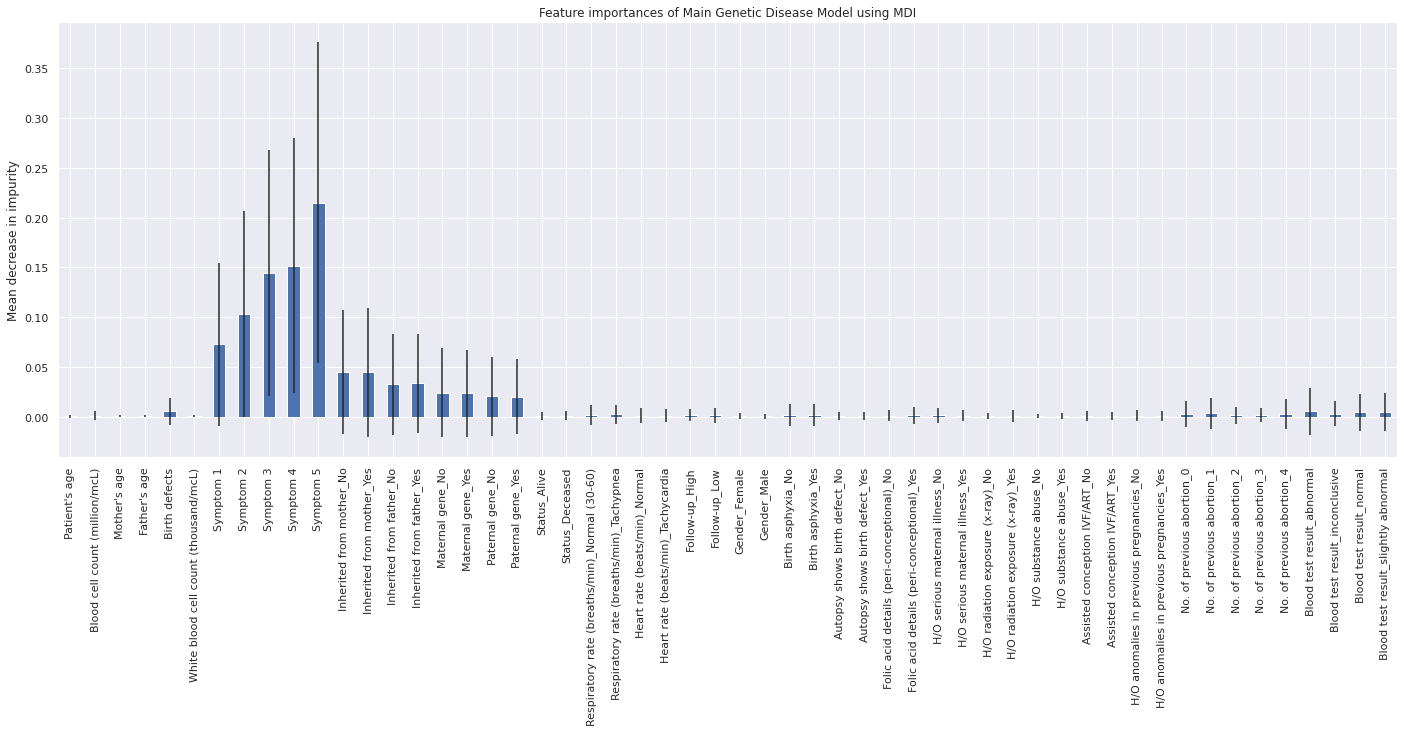

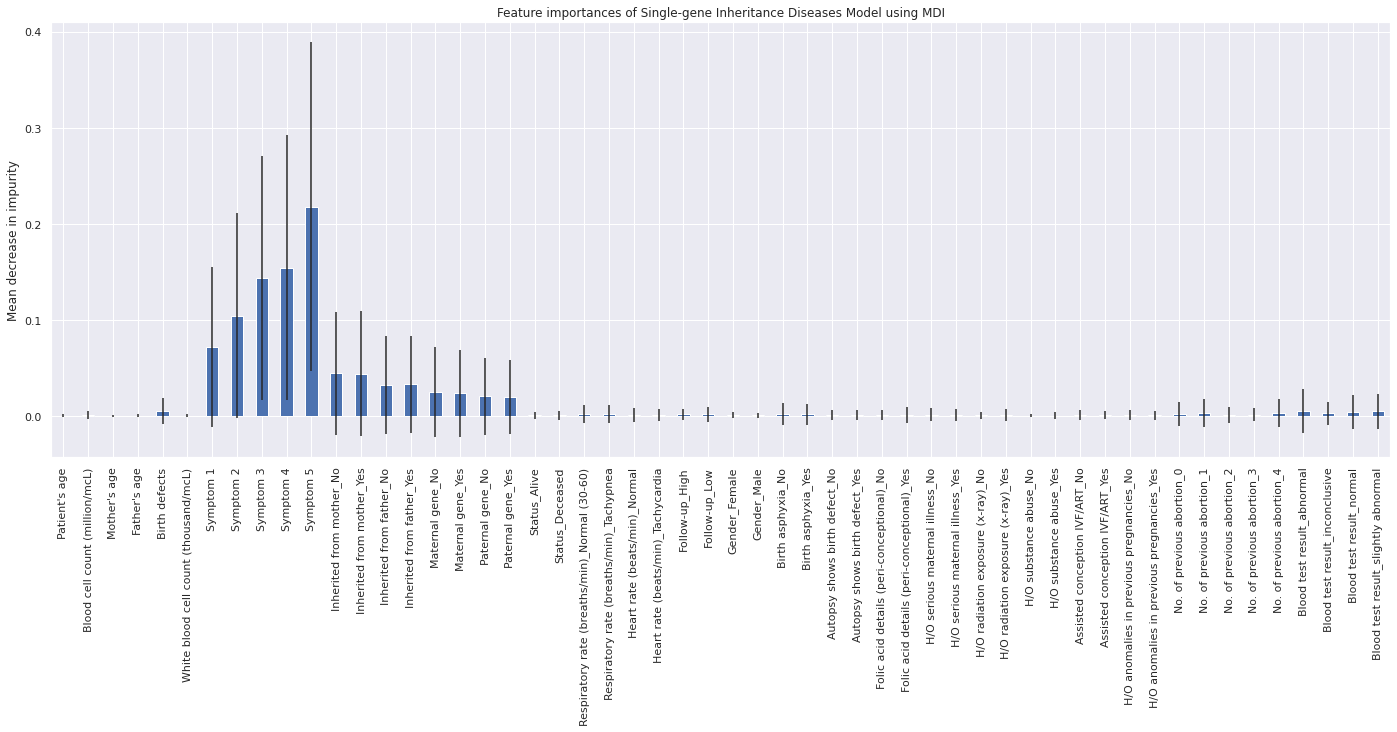

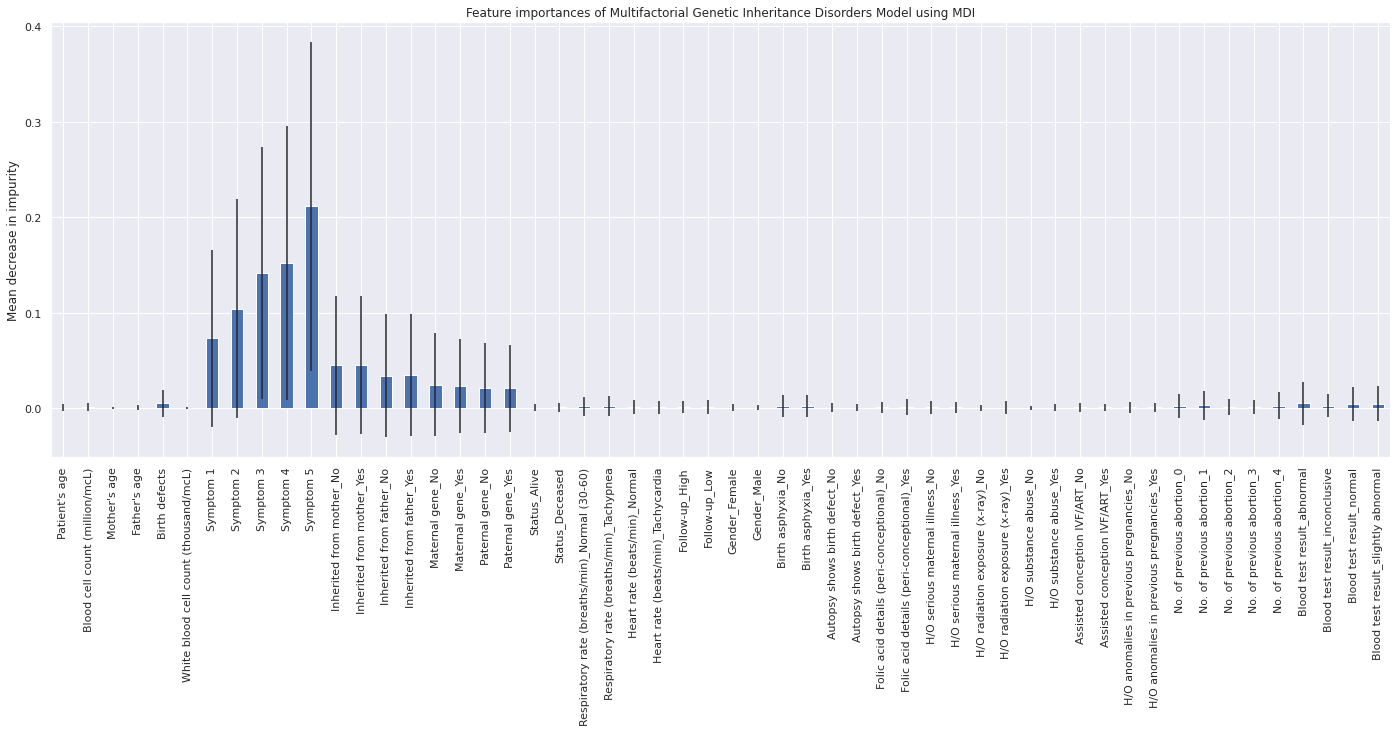

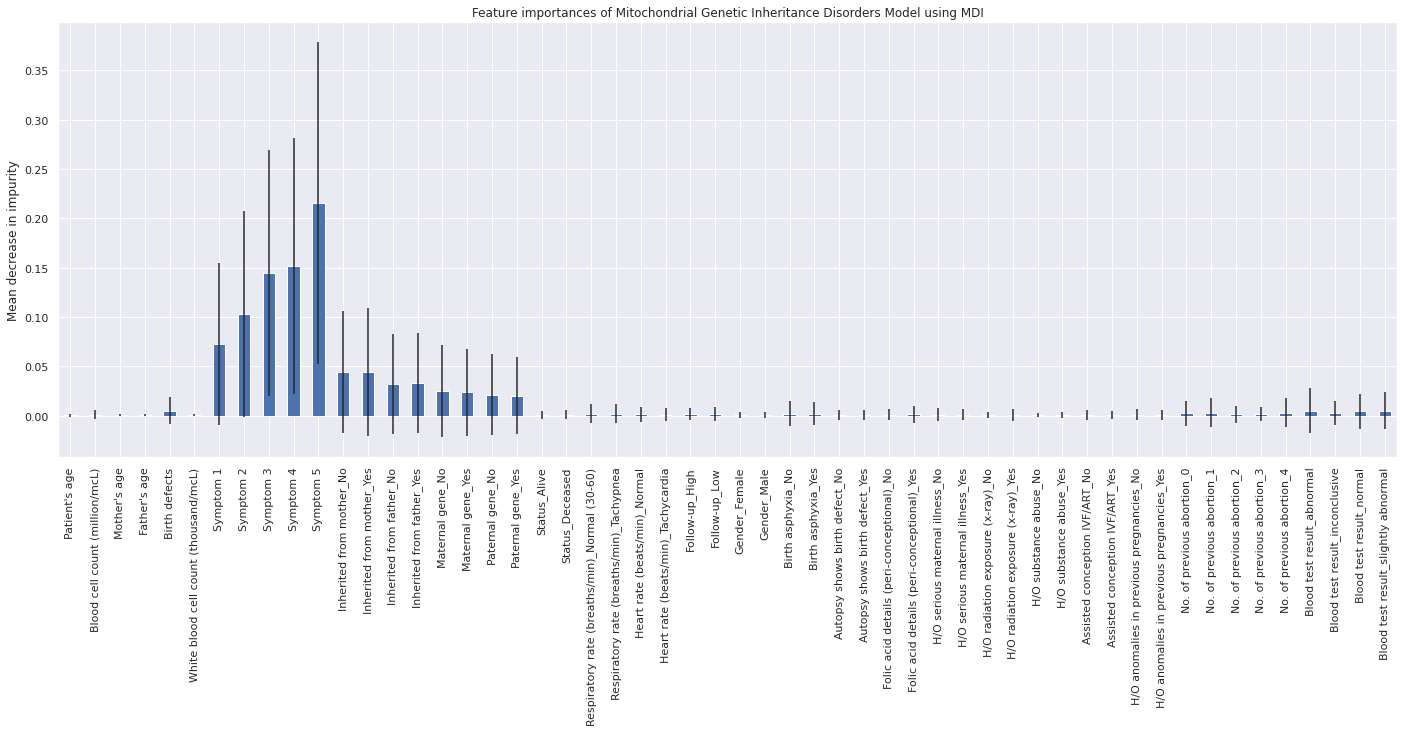

In [ ]:
# Completed
# Stratify with main and subclass
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
def accuracy(actual, predict):
  matched = sum(actual == predict)
  acc = matched / len(pd.DataFrame(actual))
  return acc

X_GD = X.copy()
GD_encode = LabelEncoder()
X_GD['Genetic Disorder'] = GD_encode.fit_transform(data_encoded['Genetic Disorder'].ravel()) # Label encode Genetic Disorder

main_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

SG_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MF_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

MT_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

final_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}

impt_main = pd.DataFrame()
impt_MF = pd.DataFrame()
impt_SG = pd.DataFrame()
impt_MT = pd.DataFrame()

# Genetic Disorder Model Training
# Iterate the model for 30 times to get average performance
for i in range(30):
  X_train, X_test, y_train, y_test = train_test_split(X_GD, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
  smote_sample = SMOTE()
  X_train_GD_pre = X_train.drop('Genetic Disorder', axis = 1)
  X_test_GD_pre = X_test.drop('Genetic Disorder', axis = 1)
  X_train_GD, y_train_GD = smote_sample.fit_resample(X_train_GD_pre, y_train['Genetic Disorder'])
  X_test_GD, y_test_GD = smote_sample.fit_resample(X_test_GD_pre, y_test['Genetic Disorder'])

  randfor_GD = RandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -1)  # Instantiate model
  randfor_GD.fit(X_train_GD, y_train_GD) # Fit model
  main_scores['Accuracy(Train)'].append(randfor_GD.score(X_train_GD, y_train_GD)) # Train set accuracy
  main_scores['Accuracy(Test)'].append(randfor_GD.score(X_test_GD, y_test_GD))
  impt_main = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_GD.estimators_])], axis = 0)
  main_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_GD, X_train_GD, y_train_GD, cv = 5).mean()) # Train set 5-fold cross-validation
  main_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_GD, X_test_GD, y_test_GD, cv = 5).mean()) # Test set 5-fold cross-validation

# Disorder Subclass Models Training
  smote_sample = SMOTE()
  X_train_SC, y_train_SC = smote_sample.fit_resample(X_train, y_train['Disorder Subclass'])
  X_test_SC, y_test_SC = smote_sample.fit_resample(X_test, y_test['Disorder Subclass'])
  y_train_main = pd.DataFrame(GD_encode.inverse_transform(X_train_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_train_SC.index)
  y_test_main = pd.DataFrame(GD_encode.inverse_transform(X_test_SC['Genetic Disorder']), columns = ['Genetic Disorder'], index = X_test_SC.index)
  X_train_SC.drop('Genetic Disorder', axis = 1, inplace = True)
  X_test_SC.drop('Genetic Disorder', axis = 1, inplace = True)

  # Single-gene inheritance diseases Model
  y_train_SG = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Single-gene'].index]
  y_test_SG = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Single-gene'].index]
  X_train_SG = X_train_SC.loc[y_train_SG.index]
  X_test_SG = X_test_SC.loc[y_test_SG.index]
  randfor_SG = RandomForestClassifier(n_estimators = 200, max_depth = 3, n_jobs = -1) # Fit model
  randfor_SG.fit(X_train_SG, y_train_SG)
  SG_scores['Accuracy(Train)'].append(randfor_SG.score(X_train_SG, y_train_SG)) # Train set accuracy
  SG_scores['Accuracy(Test)'].append(randfor_SG.score(X_test_SG, y_test_SG)) # Test set accuracy
  impt_SG = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_SG.estimators_])], axis = 0)
  SG_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_SG, X_train_SG, y_train_SG, cv = 5).mean()) # Train set 5-fold cross-validation
  SG_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_SG, X_test_SG, y_test_SG, cv = 5).mean()) # Test set 5-fold cross-validation

  # Multifactorial genetic inheritance disorders Model
  y_train_MF = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Multifactorial'].index]
  y_test_MF = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Multifactorial'].index]
  X_train_MF = X_train_SC.loc[y_train_MF.index]
  X_test_MF = X_test_SC.loc[y_test_MF.index]
  randfor_MF = RandomForestClassifier(n_estimators = 200, max_depth = 2, n_jobs = -1) # Fit model
  randfor_MF.fit(X_train_MF, y_train_MF)
  MF_scores['Accuracy(Train)'].append(randfor_MF.score(X_train_MF, y_train_MF)) # Train set accuracy
  MF_scores['Accuracy(Test)'].append(randfor_MF.score(X_test_MF, y_test_MF)) # Test set accuracy
  impt_MF = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MF.estimators_])], axis = 0)
  MF_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MF, X_train_MF, y_train_MF, cv = 5).mean()) # Train set 5-fold cross-validation
  MF_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MF, X_test_MF, y_test_MF, cv = 5).mean()) # Test set 5-fold cross-validation

  # Mitochondrial genetic inheritance disorders Model
  y_train_MT = y_train_SC.loc[y_train_main[y_train_main['Genetic Disorder'] == 'Mitochondrial'].index]
  y_test_MT = y_test_SC.loc[y_test_main[y_test_main['Genetic Disorder'] == 'Mitochondrial'].index]
  X_train_MT = X_train_SC.loc[y_train_MT.index]
  X_test_MT = X_test_SC.loc[y_test_MT.index]
  randfor_MT = RandomForestClassifier(n_estimators = 100, max_depth = 4, n_jobs = -1) # Fit model
  randfor_MT.fit(X_train_MT, y_train_MT)
  MT_scores['Accuracy(Train)'].append(randfor_MT.score(X_train_MT, y_train_MT)) # Train set accuracy
  MT_scores['Accuracy(Test)'].append(randfor_MT.score(X_test_MT, y_test_MT)) # Test set accuracy
  impt_MT = pd.concat([impt_main, pd.DataFrame([tree.feature_importances_ for tree in randfor_MT.estimators_])], axis = 0)
  MT_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor_MT, X_train_MT, y_train_MT, cv = 5).mean()) # Train set 5-fold cross-validation
  MT_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor_MT, X_test_MT, y_test_MT, cv = 5).mean()) # Test set 5-fold cross-validation
  
# Using prediced Genetic Disorder from Genetic Disorder model and input into Disorder Subclass models
  X_train_result = pd.concat([y_train_SC, y_train_main,pd.DataFrame(randfor_GD.predict(X_train_SC), columns = ['Predicted_main'])], axis = 1)

  X_train_result_MT = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Mitochondrial'].index)], 
                                              axis = 1)
  X_train_result_SG = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Single-gene'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Single-gene'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Single-gene'].index)],
                                              axis = 1)
  X_train_result_MF = pd.concat([X_train_result[X_train_result['Predicted_main'] == 'Multifactorial'], 
                                pd.DataFrame(randfor_MT.predict(X_train_SC.loc[X_train_result[X_train_result['Predicted_main'] == 'Multifactorial'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_train_result[X_train_result['Predicted_main'] == 'Multifactorial'].index)],
                                              axis = 1)
  X_train_result_final = pd.concat([X_train_result_MT,X_train_result_SG,X_train_result_MF],axis = 0)
  final_scores['Accuracy(Train)'].append(accuracy(X_train_result_final['Disorder Subclass'], X_train_result_final['Predicted_sub']))

  X_test_result = pd.concat([y_test_SC, y_test_main, pd.DataFrame(randfor_GD.predict(X_test_SC), columns = ['Predicted_main'])], axis = 1)

  X_test_result_MT = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Mitochondrial'].index)], 
                                              axis = 1)
  X_test_result_SG = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Single-gene'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Single-gene'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Single-gene'].index)],
                                              axis = 1)
  X_test_result_MF = pd.concat([X_test_result[X_test_result['Predicted_main'] == 'Multifactorial'], 
                                pd.DataFrame(randfor_MT.predict(X_test_SC.loc[X_test_result[X_test_result['Predicted_main'] == 'Multifactorial'].index]), 
                                              columns = ['Predicted_sub'],
                                              index = X_test_result[X_test_result['Predicted_main'] == 'Multifactorial'].index)],
                                              axis = 1)
  X_test_result_final = pd.concat([X_test_result_MT,X_test_result_SG,X_test_result_MF],axis = 0)
  final_scores['Accuracy(Test)'].append(accuracy(X_test_result_final['Disorder Subclass'], X_test_result_final['Predicted_sub']))

print('Main Model')
display(pd.DataFrame(main_scores).describe())
impt_main.columns = [feature for feature in X_train_GD]
display(impt_main.describe())

print('SG Model')
display(pd.DataFrame(SG_scores).describe())
impt_SG.columns = [feature for feature in X_train_GD]
display(impt_SG.describe())

print('MT Model')
display(pd.DataFrame(MT_scores).describe())
impt_MT.columns = [feature for feature in X_train_GD]
display(impt_MT.describe())

print('MF Model')
display(pd.DataFrame(MF_scores).describe())
impt_MF.columns = [feature for feature in X_train_GD]
display(impt_MF.describe())

display(pd.DataFrame(final_scores).describe())

fig, ax = plt.subplots(figsize = (24,8))
impt_main.describe().loc['mean'].plot.bar(yerr=impt_main.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Main Genetic Disease Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_SG.describe().loc['mean'].plot.bar(yerr=impt_SG.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Single-gene Inheritance Diseases Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MF.describe().loc['mean'].plot.bar(yerr=impt_MF.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Multifactorial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig, ax = plt.subplots(figsize = (24,8))
impt_MT.describe().loc['mean'].plot.bar(yerr=impt_MT.describe().loc['std'], ax=ax)
ax.set_title("Feature importances of Mitochondrial Genetic Inheritance Disorders Model using MDI")
ax.set_ylabel("Mean decrease in impurity")